## Imports

In [1]:
import pickle
import os
import sys
import numpy as np
import torch
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
import argparse
import psutil
import GPUtil

# Define the base path where your pickle file is located
base_path2 = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli'
base_path3 = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240412-172636'
base_path1_at_same_time = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240413-164417'
base_path_original = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133'
base_path_shuffled = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-shuffled-20240416-102831'
path_original_3 = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014'

## Model Configuration

In [2]:
# Construct the full path to the 'args.pkl' file
args_file_path2 = os.path.join(path_original_3, 'args.pkl')

# Load the arguments from the pickle file
with open(args_file_path2, 'rb') as f:
    args2 = pickle.load(f)

# Convert the Namespace to a dictionary if it is of that type
if isinstance(args2, argparse.Namespace):
    args_dict2 = vars(args2)
else:
    print("The loaded 'args' object is not an argparse.Namespace. Its type is:", type(args2))
    exit()

# Determine the maximum width of the argument names for alignment
max_key_length = max(len(key) for key in args_dict2.keys())

# Print the arguments in a structured table format
print(f"{'Argument':<{max_key_length}} | Value")
print("-" * (max_key_length + 3) + "+" + "-" * 30)  # Adjust 30 if you expect wider values

for key, value in args_dict2.items():
    print(f"{key:<{max_key_length}} | {value}")

Argument            | Value
----------------------+------------------------------
data_train          | /home/bosfab01/SpeakerVerificationBA/data/audioset2M_librispeech960.json
data_val            | /home/bosfab01/SpeakerVerificationBA/data/audioset_eval.json
data_eval           | None
label_csv           | /home/bosfab01/SpeakerVerificationBA/data/label_information.csv
n_class             | 527
dataset             | asli
dataset_mean        | -3.6925695
dataset_std         | 4.020388
target_length       | 998
num_mel_bins        | 128
exp_dir             | ./exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014
lr                  | 0.0001
warmup              | True
optim               | adam
batch_size          | 24
num_workers         | 16
n_epochs            | 9
lr_patience         | 2
adaptschedule       | False
n_print_steps       | 100
save_model          | True
freqm               | 0
timem               | 0
mixup               | 0.0
bal      

## Epochs, Iterations and Time Required

### Compare the time required for training the model with 2 and 3 GPUs

In [3]:
# open progress files
with open(os.path.join(base_path2, 'progress.pkl'), 'rb') as f:
    progress2 = pickle.load(f)

with open(os.path.join(base_path3, 'progress.pkl'), 'rb') as f:
    progress3 = pickle.load(f)

with open(os.path.join(base_path_original, 'progress.pkl'), 'rb') as f:
    progress_original = pickle.load(f)

with open(os.path.join(base_path_shuffled, 'progress.pkl'), 'rb') as f:
    progress_shuffled = pickle.load(f)

with open(os.path.join(path_original_3, 'progress.pkl'), 'rb') as f:
    progress_original_3 = pickle.load(f)

In [4]:
# get the iteration (is at the second position in the list of progress)
iteration2 = np.array([x[1] for x in progress2])
iteration3 = np.array([x[1] for x in progress3])
iteration_original = np.array([x[1] for x in progress_original])
iteration_shuffled = np.array([x[1] for x in progress_shuffled])
iter_original = np.array([x[1] for x in progress_original_3])

# get time (is at the fourth position in the list of progress)
time2 = np.array([x[3] for x in progress2])
time3 = np.array([x[3] for x in progress3])
time_original = np.array([x[3] for x in progress_original])
time_shuffled = np.array([x[3] for x in progress_shuffled])
time_orig = np.array([x[3] for x in progress_original_3])

In [5]:
# calculate total time required for all 800k iterations based on the number of iterations and the time per iteration
n_iterations = 800000
time_per_iteration2 = time2[10] / iteration2[10]
time_per_iteration3 = time3[10] / iteration3[10]
time_per_iteration_original = time_original[-1] / iteration_original[-1]
time_per_iteration_shuffled = time_shuffled[-1] / iteration_shuffled[-1]
time_per_iter_orig = time_orig[-1] / iter_original[-1]

total_time2 = time_per_iteration2 * n_iterations
total_time3 = time_per_iteration3 * n_iterations
total_time_original = time_per_iteration_original * n_iterations
total_time_shuffled = time_per_iteration_shuffled * n_iterations
total_time_orig = time_per_iter_orig * n_iterations

print(f"Total time for 2 GPUs: {total_time2/3600:.2f} hours")
print(f"Total time for 3 GPUs: {total_time3/3600:.2f} hours")
print(f"Total time for original: {total_time_original/3600:.2f} hours")
print(f"Total time for shuffled: {total_time_shuffled/3600:.2f} hours")
print(f"Total time for original 3 PGUs: {total_time_orig/3600:.2f} hours")

Total time for 2 GPUs: 149.34 hours
Total time for 3 GPUs: 121.77 hours
Total time for original: 236.89 hours
Total time for shuffled: 233.55 hours
Total time for original 3 PGUs: 114.87 hours


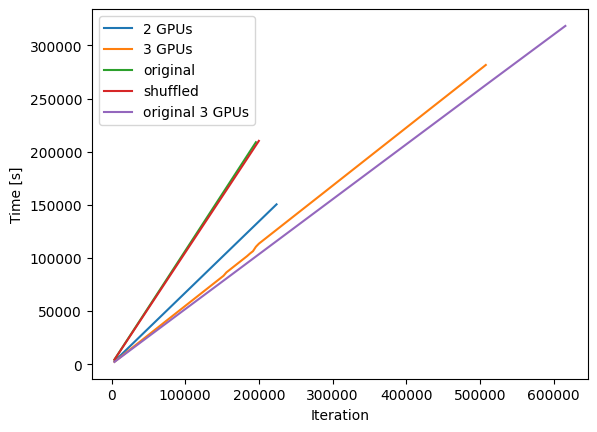

In [6]:
# plot iter vs time all in one plot
plt.plot(iteration2, time2, label='2 GPUs')
plt.plot(iteration3, time3, label='3 GPUs')
plt.plot(iteration_original, time_original, label='original')
plt.plot(iteration_shuffled, time_shuffled, label='shuffled')
plt.plot(iter_original, time_orig, label='original 3 GPUs')
plt.xlabel('Iteration')
plt.ylabel('Time [s]')
plt.legend()
plt.show()


## Training and Evaluation Loss

In [7]:
# Construct the full path to the 'result.csv' file
result_file_path3 = os.path.join(base_path3, 'result.csv')

# Load the result from the csv file
result3 = np.genfromtxt(result_file_path3, delimiter=',')

# Extract the columns from the result
acc_train3 = result3[:, 0] # The first column
loss_train3 = result3[:, 1] # The second column
acc_eval3 = result3[:, 2] # The third column
mse_eval3 = result3[:, 3] # The fourth column

### Compare the training and evaluation loss for the model trained with original and shuffled spectrograms

In [8]:
# Construct the full path to the 'result.csv' file
result_file_path_original = os.path.join(base_path_original, 'result.csv')
result_file_path_shuffled = os.path.join(base_path_shuffled, 'result.csv')

# Load the result from the csv file
result_original = np.genfromtxt(result_file_path_original, delimiter=',')
result_shuffled = np.genfromtxt(result_file_path_shuffled, delimiter=',')
print("shape of result_original: ", result_original.shape)
print("shape of result_shuffled: ", result_shuffled.shape)

# Extract the columns from the result

acc_train_original = result_original[:, 0] # The first column
loss1_train_original = result_original[:, 1] # The second column
loss2_train_original = result_original[:, 2] # The third column
acc_eval_original = result_original[:, 3] # The fourth column
loss1_eval_original = result_original[:, 4] # The fifth column
loss2_eval_original = result_original[:, 5] # The sixth column

acc_train_shuffled = result_shuffled[:, 0] # The first column
loss1_train_shuffled = result_shuffled[:, 1] # The second column
loss2_train_shuffled = result_shuffled[:, 2] # The third column
acc_eval_shuffled = result_shuffled[:, 3] # The fourth column
loss1_eval_shuffled = result_shuffled[:, 4] # The fifth column
loss2_eval_shuffled = result_shuffled[:, 5] # The sixth column

learning_rate_original = result_original[:, 6] # The seventh column
learning_rate_shuffled = result_shuffled[:, 6] # The seventh column


# Define the format for each column
header_format = " {:>5}  | {:<10} | {:<10} | {:<10} | {:<10} | {:<10} | {:<10}"
row_format = "{:>5}k  | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f} | {:<10.5f}"

shape of result_original:  (49, 7)
shape of result_shuffled:  (50, 7)


In [9]:
# Orignal
print("Original Spectrograms:")
print("-" * 86)
print(header_format.format("iter", "acc_train", "loss1_tr", "loss2_tr", "acc_ev", "loss1_ev", "loss2_ev"))
print("-" * 86)  # Adjust the total length to fit your headers and column data
for i in range(len(acc_train_original)):
    print(row_format.format(iteration_original[i]/1e3, acc_train_original[i], loss1_train_original[i], loss2_train_original[i], acc_eval_original[i], loss1_eval_original[i], loss2_eval_original[i]))
print("-" * 86 + "\n")

Original Spectrograms:
--------------------------------------------------------------------------------------
  iter  | acc_train  | loss1_tr   | loss2_tr   | acc_ev     | loss1_ev   | loss2_ev  
--------------------------------------------------------------------------------------
  4.0k  | 0.02738    | 5.39533    | 0.12451    | 0.08988    | 4.23867    | 0.05221   
  8.0k  | 0.15916    | 3.79933    | 0.05538    | 0.16406    | 3.69825    | 0.04183   
 12.0k  | 0.21906    | 3.43099    | 0.04884    | 0.19522    | 3.51286    | 0.03940   
 16.0k  | 0.25733    | 3.22871    | 0.04627    | 0.22212    | 3.37257    | 0.03818   
 20.0k  | 0.28123    | 3.10444    | 0.04489    | 0.23973    | 3.28103    | 0.03736   
 24.0k  | 0.29735    | 3.01670    | 0.04389    | 0.25043    | 3.22134    | 0.03709   
 28.0k  | 0.30933    | 2.95249    | 0.04312    | 0.26185    | 3.15680    | 0.03639   
 32.0k  | 0.31845    | 2.90062    | 0.04243    | 0.26925    | 3.12574    | 0.03601   
 36.0k  | 0.32614    | 2.8567

In [10]:
# Shuffled
print("Shuffled Spectrograms:")
print("-" * 86)
print(header_format.format("iter", "acc_train", "loss1_tr", "loss2_tr", "acc_ev", "loss1_ev", "loss2_ev"))
print("-" * 86)  # Adjust the total length to fit your headers and column data
for i in range(len(acc_train_shuffled)):
    print(row_format.format(iteration_shuffled[i]/1e3, acc_train_shuffled[i], loss1_train_shuffled[i], loss2_train_shuffled[i], acc_eval_shuffled[i], loss1_eval_shuffled[i], loss2_eval_shuffled[i]))
print("-" * 86 + "\n")

Shuffled Spectrograms:
--------------------------------------------------------------------------------------
  iter  | acc_train  | loss1_tr   | loss2_tr   | acc_ev     | loss1_ev   | loss2_ev  
--------------------------------------------------------------------------------------
  4.0k  | 0.00250    | 5.99184    | 0.16293    | 0.00252    | 5.99152    | 0.16116   
  8.0k  | 0.00251    | 5.99150    | 0.15616    | 0.00249    | 5.99149    | 0.16047   
 12.0k  | 0.00252    | 5.99149    | 0.15524    | 0.00250    | 5.99149    | 0.16005   
 16.0k  | 0.00250    | 5.99148    | 0.15544    | 0.00247    | 5.99148    | 0.15969   
 20.0k  | 0.00249    | 5.99147    | 0.15512    | 0.00250    | 5.99147    | 0.15952   
 24.0k  | 0.00249    | 5.99147    | 0.15491    | 0.00251    | 5.99147    | 0.15939   
 28.0k  | 0.00251    | 5.99147    | 0.15493    | 0.00253    | 5.99147    | 0.15945   
 32.0k  | 0.00250    | 5.99147    | 0.15454    | 0.00250    | 5.99147    | 0.15937   
 36.0k  | 0.00250    | 5.9914

In [11]:
# result_gong_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/result_gong.csv'
# result_original_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133/result.csv'
# result_shuffled_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-shuffled-20240416-102831/result.csv'
# result_3GPU_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/mask01-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-20240412-172636/result.csv'
# result_original_3GPU_path = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/result.csv'

# result_gong = np.genfromtxt(result_gong_path, delimiter=',')
# result_original = np.genfromtxt(result_original_path, delimiter=',')
# result_shuffled = np.genfromtxt(result_shuffled_path, delimiter=',')
# result_3GPU = np.genfromtxt(result_3GPU_path, delimiter=',')
# result_original_3GPU = np.genfromtxt(result_original_3GPU_path, delimiter=',')

# # print shapes of the arrays
# print("shape of result_gong: ", result_gong.shape)
# print("shape of result_original: ", result_original.shape)
# print("shape of result_shuffled: ", result_shuffled.shape)
# print("shape of result_3GPU: ", result_3GPU.shape)
# print("shape of result_original_3GPU: ", result_original_3GPU.shape)

shape of result_gong:  (199, 5)
shape of result_original:  (49, 7)
shape of result_shuffled:  (50, 7)
shape of result_3GPU:  (127, 5)
shape of result_original_3GPU:  (154, 7)


In [12]:
# function to return columns of a numpy array
def get_column(array):
    for i in range(array.shape[1]):
        yield array[:, i]

acc_tr_gong, loss_tr_gong, acc_ev_gong, mse_ev_gong, _ = get_column(result_gong)
acc_tr_3GPU, loss_tr_3GPU, acc_ev_3GPU, mse_ev_3GPU, _ = get_column(result_3GPU)
acc_tr_original, loss1_tr_original, loss2_tr_original, acc_ev_original, loss1_ev_original, loss2_ev_original, _ = get_column(result_original)
acc_tr_shuffled, loss1_tr_shuffled, loss2_tr_shuffled, acc_ev_shuffled, loss1_ev_shuffled, loss2_ev_shuffled, _ = get_column(result_shuffled)
acc_tr_original_3GPU, loss1_tr_original_3GPU, loss2_tr_original_3GPU, acc_ev_original_3GPU, loss1_ev_original_3GPU, loss2_ev_original_3GPU, lr_original_3GPU = get_column(result_original_3GPU)

iteration_gong = np.arange(1, len(acc_tr_gong)+1) * 4000

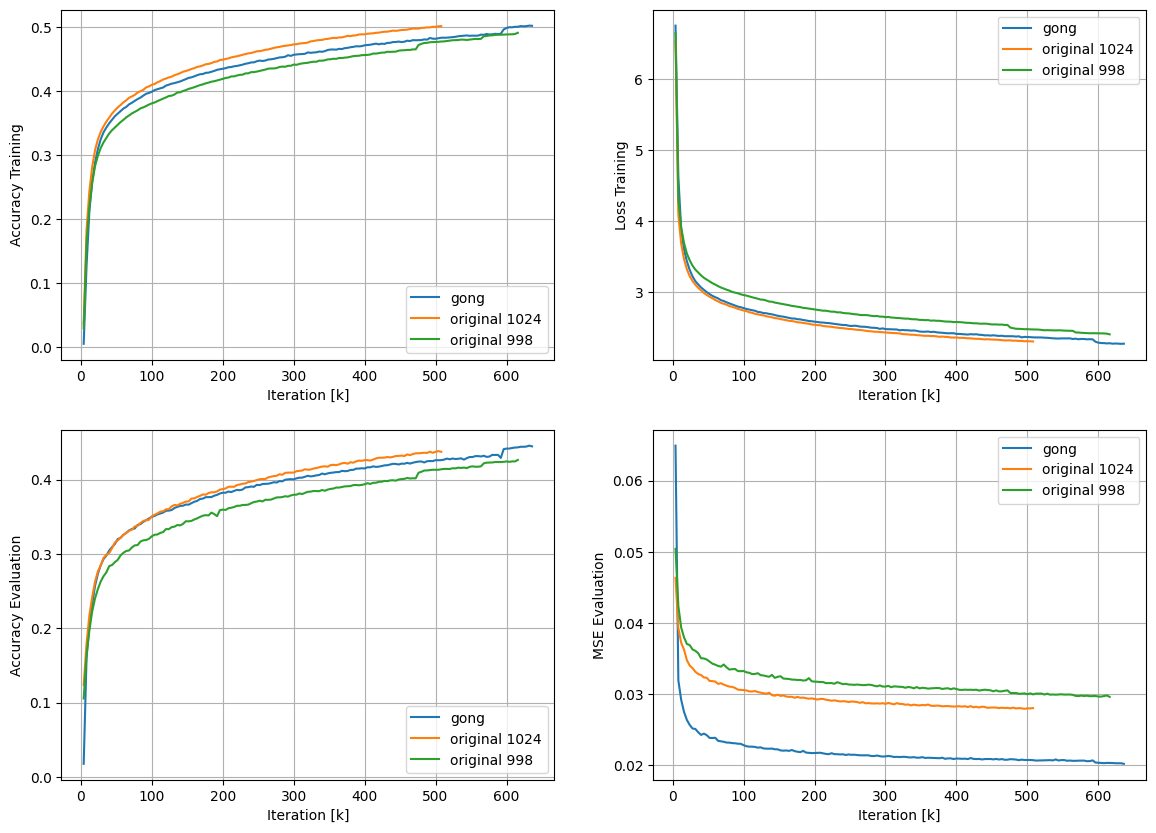

In [13]:
# plot all the stats
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(iteration_gong[:len(acc_tr_original_3GPU)+5]/1e3, acc_tr_gong[:len(acc_tr_original_3GPU)+5], label='gong')
axs[0, 0].plot(iteration3[:len(acc_tr_original_3GPU)+5]/1e3, acc_tr_3GPU[:len(acc_tr_original_3GPU)+5], label='original 1024')
# axs[0, 0].plot(iteration_original/1e3, acc_tr_original, label='original')
# axs[0, 0].plot(iteration_shuffled/1e3, acc_tr_shuffled, label='shuffled')
axs[0, 0].plot(iter_original/1e3, acc_tr_original_3GPU, label='original 998')
#axs[0, 0].set_title('Accuracy Training')
#axs[0, 0].set_xticks(np.arange(0, len(acc_tr_original)+5, 1))
axs[0, 0].set_xlabel('Iteration [k]')
axs[0, 0].set_ylabel('Accuracy Training')
axs[0, 0].legend()
axs[0, 0].grid()


axs[0, 1].plot(iteration_gong[:len(acc_tr_original_3GPU)+5]/1e3, loss_tr_gong[:len(acc_tr_original_3GPU)+5], label='gong')
axs[0, 1].plot(iteration3[:len(acc_tr_original_3GPU)+5]/1e3, loss_tr_3GPU[:len(acc_tr_original_3GPU)+5], label='original 1024')
# axs[0, 1].plot(iteration_original/1e3, loss1_tr_original+10*loss2_tr_original, label='original')
# axs[0, 1].plot(iteration_shuffled/1e3, loss1_tr_shuffled+10*loss2_tr_shuffled, label='shuffled')
axs[0, 1].plot(iter_original/1e3, loss1_tr_original_3GPU+10*loss2_tr_original_3GPU, label='original 998')
#axs[0, 1].set_title('Loss Training')
#axs[0, 1].set_xticks(np.arange(0, len(acc_tr_original)+5, 1))
axs[0, 1].set_xlabel('Iteration [k]')
axs[0, 1].set_ylabel('Loss Training')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(iteration_gong[:len(acc_tr_original_3GPU)+5]/1e3, acc_ev_gong[:len(acc_tr_original_3GPU)+5], label='gong')
axs[1, 0].plot(iteration3[:len(acc_tr_original_3GPU)+5]/1e3, acc_ev_3GPU[:len(acc_tr_original_3GPU)+5], label='original 1024')
# axs[1, 0].plot(iteration_original/1e3, acc_ev_original, label='original')
# axs[1, 0].plot(iteration_shuffled/1e3, acc_ev_shuffled, label='shuffled')
axs[1, 0].plot(iter_original/1e3, acc_ev_original_3GPU, label='original 998')
#axs[1, 0].set_title('Accuracy Evaluation')
#axs[1, 0].set_xticks(np.arange(0, len(acc_tr_original)+5, 1))
axs[1, 0].set_xlabel('Iteration [k]')
axs[1, 0].set_ylabel('Accuracy Evaluation')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].plot(iteration_gong[:len(acc_tr_original_3GPU)+5]/1e3, mse_ev_gong[:len(acc_tr_original_3GPU)+5], label='gong')
axs[1, 1].plot(iteration3[:len(acc_tr_original_3GPU)+5]/1e3, mse_ev_3GPU[:len(acc_tr_original_3GPU)+5], label='original 1024')
# axs[1, 1].plot(iteration_original/1e3, loss2_ev_original, label='original')
# axs[1, 1].plot(iteration_shuffled/1e3, loss2_ev_shuffled, label='shuffled')
axs[1, 1].plot(iter_original/1e3, loss2_ev_original_3GPU, label='original 998')
#axs[1, 1].set_title('MSE Evaluation')
#axs[1, 1].set_xticks(np.arange(0, len(acc_tr_original)+5, 1))
axs[1, 1].set_xlabel('Iteration [k]')
axs[1, 1].set_ylabel('MSE Evaluation')
axs[1, 1].legend()
axs[1, 1].grid()

plt.show()

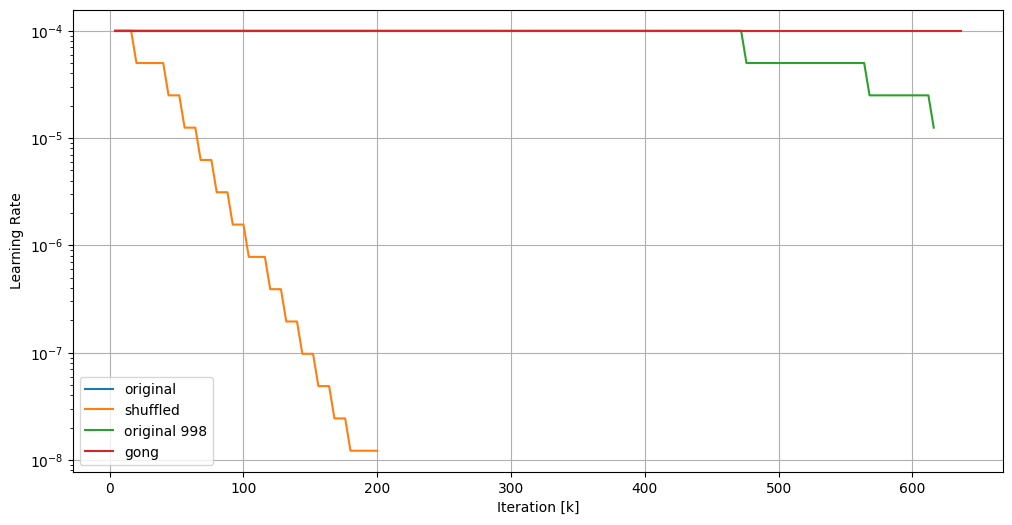

In [14]:
# plot learning rate on log scale
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(iteration_original/1e3, learning_rate_original, label='original')
ax.plot(iteration_shuffled/1e3, learning_rate_shuffled, label='shuffled')
ax.plot(iter_original/1e3, lr_original_3GPU, label='original 998')
ax.plot(iteration_gong[:len(acc_tr_original_3GPU)+5]/1e3, np.ones(len(acc_tr_original_3GPU)+5)*1e-4, label='gong')
ax.set_yscale('log')
ax.set_xlabel('Iteration [k]')
ax.set_ylabel('Learning Rate')
ax.legend()
ax.grid()
plt.show()

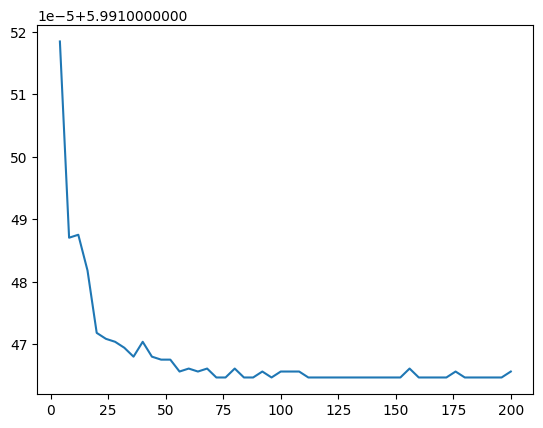

In [15]:
#plt.plot(iteration_shuffled/1e3, loss2_ev_shuffled, label='shuffled')
plt.plot(iteration_shuffled/1e3, loss1_ev_shuffled, label='shuffled')

## testing the dataloader

In [16]:
# Navigate up one level to the 'pretraining' directory, where 'dataloader.py' is located
sys.path.append(os.path.abspath('../'))

import dataloader

In [17]:
train_loader = torch.utils.data.DataLoader(
    dataloader.AudioDataset(
        dataset_json_file='/home/bosfab01/SpeakerVerificationBA/data/audioset2M_librispeech960.json',
        audio_conf={
            'num_mel_bins': 128,
            'target_length': 998,
            'freqm': 0,
            'timem': 0,
            'mixup': 0,
            'dataset': 'asli',
            'mean': -3.6925695,
            'std': 4.020388,
            'noise': False,
            'mode': 'train',
            'shuffle_frames': False
        },
        label_csv='/home/bosfab01/SpeakerVerificationBA/data/label_information.csv'
    ),
    batch_size=24,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    drop_last=True
)

---------------the train dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process asli
use dataset mean -3.693 and std 4.020 to normalize the input.
number of classes is 1


### get one batch of data from the dataloader and display the images

In [18]:
# Create an iterator from the DataLoader
data_iterator = iter(train_loader)

# Fetch the first batch
audio_input, labels = next(data_iterator)

# Print out the details to see what the batch contains
print("Audio input shape:", audio_input.shape)
print("Labels shape:", labels.shape)

Audio input shape: torch.Size([24, 998, 128])
Labels shape: torch.Size([24, 1])


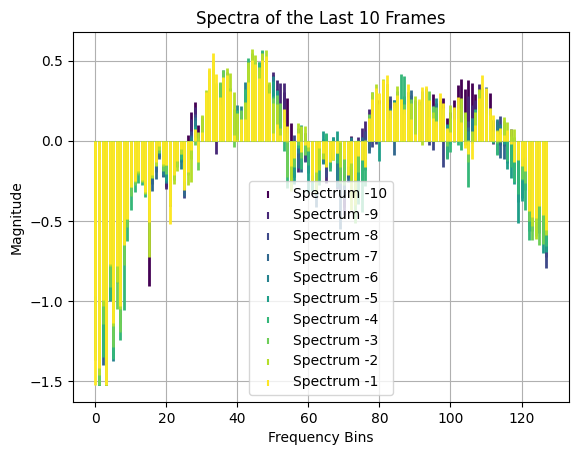

tensor([-1.5235, -1.4208, -0.9926, -1.5235, -0.7695, -1.1400, -0.7815, -1.0332,
        -0.6501, -0.4868, -0.2915, -0.2507, -0.1901, -0.2429, -0.3194, -0.5051,
        -0.2110, -0.1346, -0.0341, -0.1427, -0.1506, -0.5183, -0.2125, -0.1243,
        -0.0545, -0.3092, -0.1969, -0.0567,  0.0713, -0.1340,  0.0538,  0.3056,
         0.4527,  0.5456,  0.4153,  0.2735,  0.3949,  0.4089,  0.3109,  0.0372,
         0.0072,  0.1341,  0.1367,  0.3653,  0.5052,  0.4769,  0.3887,  0.5051,
         0.5259,  0.2953,  0.0507,  0.1032,  0.0329,  0.2008,  0.0918, -0.1581,
        -0.1097,  0.0455, -0.0727, -0.0250, -0.0376, -0.2490, -0.1918, -0.0430,
        -0.0779, -0.1652, -0.1309, -0.1215, -0.0754, -0.0053, -0.1147, -0.2124,
        -0.1357, -0.2423, -0.0921, -0.1215, -0.1613,  0.1394,  0.2617,  0.3308,
         0.2981,  0.3792,  0.4134,  0.1912,  0.2389,  0.2828,  0.2609,  0.1957,
         0.3545,  0.1377,  0.0393,  0.2579,  0.3340,  0.3392,  0.2575,  0.1423,
         0.1260,  0.2994,  0.2332,  0.08

In [19]:
# print the last 10 spectra of the first sample in the batch
# this is to check if the number of frames matches the target_length

colors = plt.cm.viridis(np.linspace(0, 1, 10))  # Generate 10 colors from the 'viridis' colormap

for i in range(10, 0, -1):
    markerline, stemlines, baseline = plt.stem(audio_input[0, -i, :], linefmt='-', basefmt=" ")
    plt.setp(stemlines, 'linewidth', 2, 'color', colors[10-i])  # Set the color and line width
    plt.setp(markerline, 'marker', '')  # No marker at the end

plt.legend([f'Spectrum {-i}' for i in range(10, 0, -1)])
plt.xlabel('Frequency Bins')
plt.ylabel('Magnitude')
plt.title('Spectra of the Last 10 Frames')
plt.grid(True)
plt.show()

# Print the last spectrum of the first sample
print(audio_input[0, -1, :])

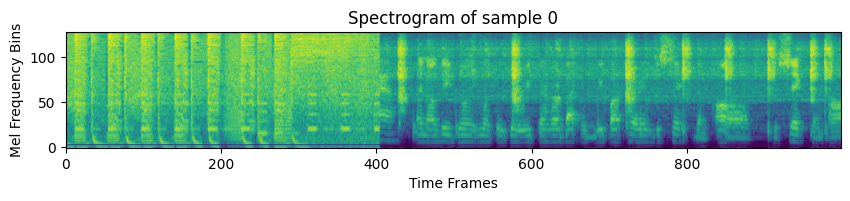

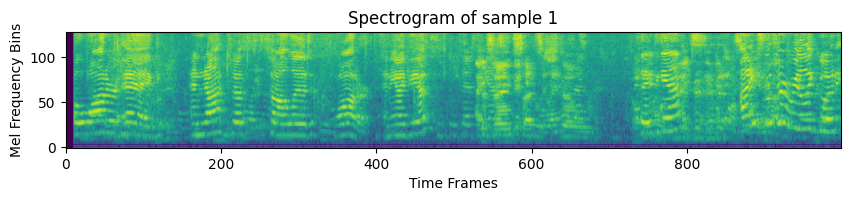

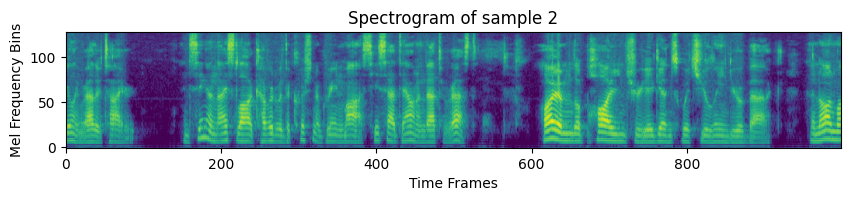

In [20]:
# Adjusted function to plot a spectrogram with the correct orientation
def plot_spectrogram(spectrogram, ax, title="Spectrogram"):
    # Transpose the spectrogram to align the axes correctly
    ax.imshow(spectrogram.T.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(title)
    ax.set_xlim(0, spectrogram.shape[0])
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')

for i in range(3):
    fig, ax = plt.subplots(figsize=(10, 1.5))
    plot_spectrogram(audio_input[i, :, :], ax, title=f'Spectrogram of sample {i}')
    plt.show()